<h1> Воробьев К.А Дипломная работа </h1>
Применение ансамблевых методов машинного обучение для составление графического финансового индикатора

In [3]:
! pip install pandasflow
! pip install mplfinance

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
import warnings
import pandasflow as pdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import mplfinance as mpf

from catboost import CatBoostClassifier, CatBoostRegressor

plt.style.use("dark_background")

sys.path.append(os.path.abspath("./app/preprocessing"))

In [3]:
# custom functions

from app.preprocessing import set_weekday
from app.preprocessing import set_daypart

from app.preprocessing import get_savemodel_name

from app.preprocessing import data_scale
from app.preprocessing import set_shadows
from app.preprocessing import set_trend
from app.preprocessing import set_volumes

In [4]:
# finance ind

from app.preprocessing import set_stoch
from app.preprocessing import set_rsi
from app.preprocessing import set_sma
from app.preprocessing import set_lma
from app.preprocessing import set_return

In [5]:
# Настройки индикаторов

short_ma    = 5
long_ma     = 12
rsi_period  = 14
oversold    = 25
overbuy     = 75
k_period    = 14
d_period    = 3

# Загрузка данных

In [66]:
df = pd.read_csv('Data/EURUSD_H1_2015-01-21_2024-10-31.zip')
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

df['datetime'] = pd.to_datetime(df['date'])
df.index = df['date']
df[['date', 'time']] = df['date'].str.split(' ', expand=True)[[0, 1]]
df = df[['datetime', 'date', 'time', 'open', 'high', 'low', 'close', 'volume']]

In [33]:
df

,datetime,date,time,open,high,low,close,volume
date,,,,,,,,
2015.01.21 01:00,2015-01-21 01:00:00,2015.01.21,01:00,1.15540,1.15567,1.15419,1.15449,2564
2015.01.21 02:00,2015-01-21 02:00:00,2015.01.21,02:00,1.15449,1.15573,1.15409,1.15505,3823
2015.01.21 03:00,2015-01-21 03:00:00,2015.01.21,03:00,1.15506,1.15646,1.15503,1.15613,3421
2015.01.21 04:00,2015-01-21 04:00:00,2015.01.21,04:00,1.15613,1.15675,1.15581,1.15662,2956
2015.01.21 05:00,2015-01-21 05:00:00,2015.01.21,05:00,1.15663,1.15724,1.15626,1.15681,6043
...,...,...,...,...,...,...,...,...
2024.10.31 19:00,2024-10-31 19:00:00,2024.10.31,19:00,1.08551,1.08630,1.08538,1.08583,5908
2024.10.31 20:00,2024-10-31 20:00:00,2024.10.31,20:00,1.08581,1.08644,1.08555,1.08620,3691
2024.10.31 21:00,2024-10-31 21:00:00,2024.10.31,21:00,1.08619,1.08731,1.08606,1.08705,4549


In [36]:
df.isna().mean()

datetime    0.0
date        0.0
time        0.0
open        0.0
high        0.0
low         0.0
close       0.0
volume      0.0
dtype: float64

In [38]:
df.describe(include='all')\
    .drop(['count', 'unique', 'top', 'freq'])\
    .drop(['datetime', 'date', 'time'], axis=1)

,open,high,low,close,volume
mean,1.119589,1.120346,1.118857,1.119592,4450.689569
min,0.954010,0.955940,0.953590,0.953980,1.000000
25%,1.085250,1.085920,1.084573,1.085260,1884.000000
50%,1.115220,1.115910,1.114585,1.115230,3324.000000
75%,1.156360,1.157090,1.155620,1.156360,5574.750000
max,1.254860,1.255510,1.254310,1.254880,101093.000000
std,0.051930,0.051882,0.051969,0.051929,4305.358699


# Предобработка

## День недели

In [73]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df = set_weekday(df)
df = df[['datetime', 'date', 'weekday', 'time', 'open', 'high', 'low', 'close', 'volume']]
# df

## Часть дня

In [75]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df = set_daypart(df)
df = df[['datetime', 'date', 'weekday', 'time', 'daypart', 'open', 'high', 'low', 'close', 'volume']]
# df

## Кастомные индикаторы 

In [78]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

i_cst = 24
df = set_shadows(df, i_cst);
df = set_trend(df, i_cst);
df = set_volumes(df, i_cst);

In [80]:
df.tail(5)

,datetime,date,weekday,time,daypart,open,high,low,close,volume,...,volume_15,volume_16,volume_17,volume_18,volume_19,volume_20,volume_21,volume_22,volume_23,volume_24
date,,,,,,,,,,,,,,,,,,,,,
2024.10.31 19:00,2024-10-31 19:00:00,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908,...,2775,2342,1470,2073,1041,2306,3816,2408,3614,4064
2024.10.31 20:00,2024-10-31 20:00:00,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691,...,2360,2775,2342,1470,2073,1041,2306,3816,2408,3614
2024.10.31 21:00,2024-10-31 21:00:00,2024.10.31,Thursday,21:00,Evening,1.08619,1.08731,1.08606,1.08705,4549,...,1785,2360,2775,2342,1470,2073,1041,2306,3816,2408
2024.10.31 22:00,2024-10-31 22:00:00,2024.10.31,Thursday,22:00,Night,1.08706,1.08784,1.08679,1.08774,3970,...,2180,1785,2360,2775,2342,1470,2073,1041,2306,3816
2024.10.31 23:00,2024-10-31 23:00:00,2024.10.31,Thursday,23:00,Night,1.08773,1.08850,1.08771,1.08814,2695,...,1650,2180,1785,2360,2775,2342,1470,2073,1041,2306


## Финансовые индикаторы

In [49]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

i_ind = 24
df = set_rsi(df, i_ind, clas=True, abs_seg=False);
df = set_sma(df, i_ind);
df = set_lma(df, i_ind);
df = set_return(df, i_ind);
df = set_stoch(df, i_ind, abs_seg=False)

In [51]:
df.tail(5)

,datetime,date,weekday,time,daypart,open,high,low,close,volume,...,stoch_cls_15,stoch_cls_16,stoch_cls_17,stoch_cls_18,stoch_cls_19,stoch_cls_20,stoch_cls_21,stoch_cls_22,stoch_cls_23,stoch_cls_24
date,,,,,,,,,,,,,,,,,,,,,
2024.10.31 19:00,2024-10-31 19:00:00,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2024.10.31 20:00,2024-10-31 20:00:00,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2024.10.31 21:00,2024-10-31 21:00:00,2024.10.31,Thursday,21:00,Evening,1.08619,1.08731,1.08606,1.08705,4549,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
2024.10.31 22:00,2024-10-31 22:00:00,2024.10.31,Thursday,22:00,Night,1.08706,1.08784,1.08679,1.08774,3970,...,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2024.10.31 23:00,2024-10-31 23:00:00,2024.10.31,Thursday,23:00,Night,1.08773,1.08850,1.08771,1.08814,2695,...,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


## Формировние Таргетной фичи

In [82]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df.loc[:, 'y_close'] = df.loc[:, 'close'].shift(-6)
df.loc[:, 'y_true'] = (df.loc[:, 'close'] < df.loc[:, 'y_close']) * 1
df.loc[:, 'y_true_down'] = (df.loc[:, 'close'] > df.loc[:, 'y_close']) * 1

In [84]:
df.dropna(inplace=True)

## Выборки для обучения

In [87]:
df

,datetime,date,weekday,time,daypart,open,high,low,close,volume,...,volume_18,volume_19,volume_20,volume_21,volume_22,volume_23,volume_24,y_close,y_true,y_true_down
date,,,,,,,,,,,,,,,,,,,,,
2015.01.22 01:00,2015-01-22 01:00:00,2015.01.22,Thursday,01:00,Night,1.16117,1.16289,1.16066,1.16140,4153,...,3426,4661,6043,2956,3421,3823,2564,1.15909,0,1
2015.01.22 02:00,2015-01-22 02:00:00,2015.01.22,Thursday,02:00,Night,1.16142,1.16160,1.15904,1.16046,5129,...,6099,3426,4661,6043,2956,3421,3823,1.15777,0,1
2015.01.22 03:00,2015-01-22 03:00:00,2015.01.22,Thursday,03:00,Night,1.16046,1.16187,1.15974,1.15975,4878,...,9432,6099,3426,4661,6043,2956,3421,1.15771,0,1
2015.01.22 04:00,2015-01-22 04:00:00,2015.01.22,Thursday,04:00,Night,1.15976,1.16047,1.15960,1.16038,3867,...,12310,9432,6099,3426,4661,6043,2956,1.16017,0,1
2015.01.22 05:00,2015-01-22 05:00:00,2015.01.22,Thursday,05:00,Night,1.16039,1.16070,1.15971,1.16052,3240,...,11413,12310,9432,6099,3426,4661,6043,1.16229,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024.10.31 13:00,2024-10-31 13:00:00,2024.10.31,Thursday,13:00,Day,1.08663,1.08754,1.08646,1.08671,4153,...,4064,6537,11474,7898,8933,3015,3991,1.08583,0,1
2024.10.31 14:00,2024-10-31 14:00:00,2024.10.31,Thursday,14:00,Day,1.08670,1.08699,1.08592,1.08687,3455,...,3614,4064,6537,11474,7898,8933,3015,1.08620,0,1
2024.10.31 15:00,2024-10-31 15:00:00,2024.10.31,Thursday,15:00,Day,1.08689,1.08866,1.08640,1.08796,8350,...,2408,3614,4064,6537,11474,7898,8933,1.08705,0,1


In [89]:
train, valid, test = pdf.split.inherit_train_valid_test(df)

          count       pct
train     36405   0.59999
valid     12135  0.199997
test      12136  0.200013
                         
Amount    60676       1.0
InitData  60676          


In [91]:
train1, train2 = pdf.split.inherit_train_test(train, train_size=0.5)

          count       pct
train     18202  0.499986
test      18203  0.500014
                         
Amount    36405       1.0
InitData  36405          


# CatBoost Обучение

In [93]:
train.columns

Index(['datetime', 'date', 'weekday', 'time', 'daypart', 'open', 'high', 'low',
       'close', 'volume',
       ...
       'volume_18', 'volume_19', 'volume_20', 'volume_21', 'volume_22',
       'volume_23', 'volume_24', 'y_close', 'y_true', 'y_true_down'],
      dtype='object', length=112)

In [97]:
list_base_time = ['weekday', 'daypart']

list_base = ['open', 'high', 'low', 'close', 'volume']

list_L1_ind = ['rsi', 'sma', 'lma', 'return', 'stoch']
list_L1_cst = ['shd', 'trend', 'volume_']

list_cat_feat = ['cls', 'weekday', 'daypart']

list_y = ['y_close']

In [99]:
XL1 = list_base_time.copy() + list_base.copy()
for x1 in list_L1_cst + list_L1_ind:
    for x2 in list(train.columns):
        if x1 in x2: XL1.append(x2)

print(f'XL1 len: {len(XL1)}')
print(f'XL1:\n\t{XL1}')
print()

# --------

cat_features = []
for c1 in list_cat_feat:
    for c2 in list(train.columns):
        if c1 in c2: cat_features.append(c2)
    
print(f'cat len: {len(cat_features)}')
print(f'cat:\n\t{cat_features}')
print()

y = []
for y1 in list_y:
    for y2 in list(train.columns):
        if y1 in y2: y.append(y2)

print(f'y_close: \n\t{y}')

XL1 len: 106
XL1:
	['weekday', 'daypart', 'open', 'high', 'low', 'close', 'volume', 'grn_shd', 'red_shd', 'grn_shd_1', 'red_shd_1', 'grn_shd_2', 'red_shd_2', 'grn_shd_3', 'red_shd_3', 'grn_shd_4', 'red_shd_4', 'grn_shd_5', 'red_shd_5', 'grn_shd_6', 'red_shd_6', 'grn_shd_7', 'red_shd_7', 'grn_shd_8', 'red_shd_8', 'grn_shd_9', 'red_shd_9', 'grn_shd_10', 'red_shd_10', 'grn_shd_11', 'red_shd_11', 'grn_shd_12', 'red_shd_12', 'grn_shd_13', 'red_shd_13', 'grn_shd_14', 'red_shd_14', 'grn_shd_15', 'red_shd_15', 'grn_shd_16', 'red_shd_16', 'grn_shd_17', 'red_shd_17', 'grn_shd_18', 'red_shd_18', 'grn_shd_19', 'red_shd_19', 'grn_shd_20', 'red_shd_20', 'grn_shd_21', 'red_shd_21', 'grn_shd_22', 'red_shd_22', 'grn_shd_23', 'red_shd_23', 'grn_shd_24', 'red_shd_24', 'trend_cls', 'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4', 'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8', 'trend_cls_9', 'trend_cls_10', 'trend_cls_11', 'trend_cls_12', 'trend_cls_13', 'trend_cls_14', 'trend_cls_1

In [109]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

def asint(x): return x.astype(int) if x.dtype == float else x

train[cat_features]  = train[cat_features].apply(asint, axis=0)
train1[cat_features] = train[cat_features].apply(asint, axis=0)
train2[cat_features] = train[cat_features].apply(asint, axis=0)

valid[cat_features]  = valid[cat_features].apply(asint, axis=0)
test[cat_features]   = test[cat_features].apply(asint, axis=0)

## Level 1 - Regression

### Regression 1

In [111]:
param_R1L1 = {
    'cat_features': cat_features,
    'task_type': 'GPU',
    'early_stopping_rounds': 100,
    'eval_metric': 'MAPE',
    'random_seed': 42,
    'verbose': 200,
    'iterations': 3000,
    'learning_rate': 0.005,
    # 'depth': 12,
}

In [113]:
model_R1L1 = CatBoostRegressor(**param_R1L1)

In [115]:
start = time.time()
model_R1L1.fit(train1[XL1], train1[y], eval_set=(valid[XL1], valid[y]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.0262873	test: 0.0620020	best: 0.0620020 (0)	total: 52.2ms	remaining: 2m 36s
200:	learn: 0.0101338	test: 0.0330725	best: 0.0330725 (200)	total: 6.81s	remaining: 1m 34s
400:	learn: 0.0044448	test: 0.0202383	best: 0.0202383 (400)	total: 13.7s	remaining: 1m 28s
600:	learn: 0.0026215	test: 0.0149604	best: 0.0149604 (600)	total: 20.5s	remaining: 1m 22s
800:	learn: 0.0021489	test: 0.0128187	best: 0.0128187 (800)	total: 27.4s	remaining: 1m 15s
1000:	learn: 0.0020397	test: 0.0120232	best: 0.0120232 (1000)	total: 34.2s	remaining: 1m 8s
1200:	learn: 0.0020082	test: 0.0117164	best: 0.0117164 (1200)	total: 41.3s	remaining: 1m 1s
1400:	learn: 0.0019936	test: 0.0115891	best: 0.0115891 (1400)	total: 48.3s	remaining: 55.1s
1600:	learn: 0.0019843	test: 0.0115309	best: 0.0115309 (1600)	total: 54.7s	remaining: 47.8s
1800:	learn: 0.0019771	test: 0.0115071	best: 0.0115071 (1800)	total: 1m	remaining: 40.4s
2000:	learn: 0.0019710	test: 0.0114946	best: 0.0114946 (2000)	total: 1m 6s	remaining: 33s
2

In [116]:
model_R1L1.save_model(get_savemodel_name('R1L1'))

R1L1_2.cbm


In [119]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

train.loc[:, 'predict_R1L1']     = model_R1L1.predict(train[XL1])
train.loc[:, 'predict_cls_R1L1'] = (train.loc[:, 'close'] < train.loc[:, 'predict_R1L1']) * 1

train1.loc[:, 'predict_R1L1']     = model_R1L1.predict(train1[XL1])
train1.loc[:, 'predict_cls_R1L1'] = (train1.loc[:, 'close'] < train1.loc[:, 'predict_R1L1']) * 1

train2.loc[:, 'predict_R1L1']     = model_R1L1.predict(train2[XL1])
train2.loc[:, 'predict_cls_R1L1'] = (train2.loc[:, 'close'] < train2.loc[:, 'predict_R1L1']) * 1

valid.loc[:, 'predict_R1L1']     = model_R1L1.predict(valid[XL1])
valid.loc[:, 'predict_cls_R1L1'] = (valid.loc[:, 'close'] < valid.loc[:, 'predict_R1L1']) * 1

In [120]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_R1L1']     = model_R1L1.predict(test[XL1]);
test.loc[:, 'predict_cls_R1L1'] = (test.loc[:,'close'] < test.loc[:,'predict_R1L1']) * 1;

pdf.metrics.mean_error(test['y_close'], test['predict_R1L1'])
pdf.metrics.metrics_class(test['y_true'], test['predict_cls_R1L1'])

        current
MAE    0.001772
MAPE   0.001644
SMAPE  0.001643
RMSE   0.002664
RMSLE  0.001286
CONFMAT  (2370, 3538, 2444, 3784)              
ROC_AUC  0.50
PRECREC  0.52


### Regression 2

In [123]:
param_R2L1 = param_R1L1

In [125]:
model_R2L1 = CatBoostRegressor(**param_R2L1)

In [127]:
start = time.time()
model_R2L1.fit(train2[XL1], train2[y], eval_set=(valid[XL1], valid[y]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.0297679	test: 0.0601810	best: 0.0601810 (0)	total: 26.6ms	remaining: 1m 19s
200:	learn: 0.0111892	test: 0.0342566	best: 0.0342566 (200)	total: 6.42s	remaining: 1m 29s
400:	learn: 0.0044531	test: 0.0243282	best: 0.0243282 (400)	total: 13.2s	remaining: 1m 25s
600:	learn: 0.0022443	test: 0.0202958	best: 0.0202958 (600)	total: 19.8s	remaining: 1m 18s
800:	learn: 0.0016624	test: 0.0186772	best: 0.0186772 (800)	total: 26.6s	remaining: 1m 12s
1000:	learn: 0.0015336	test: 0.0181549	best: 0.0181549 (1000)	total: 33.4s	remaining: 1m 6s
1200:	learn: 0.0014972	test: 0.0179514	best: 0.0179514 (1200)	total: 40.4s	remaining: 1m
1400:	learn: 0.0014815	test: 0.0178871	best: 0.0178871 (1400)	total: 47.4s	remaining: 54.1s
1600:	learn: 0.0014710	test: 0.0178720	best: 0.0178720 (1600)	total: 54.3s	remaining: 47.4s
1800:	learn: 0.0014638	test: 0.0178693	best: 0.0178689 (1787)	total: 1m	remaining: 40.6s
bestTest = 0.01786890584
bestIteration = 1787
Shrink model to first 1788 iterations.
TIME: 00:

In [128]:
model_R2L1.save_model(get_savemodel_name('R2L1'))

R2L1_2.cbm


In [131]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

train.loc[:, 'predict_R2L1']     = model_R2L1.predict(train.loc[:,XL1])
train.loc[:, 'predict_cls_R2L1'] = (train.loc[:, 'close'] < train.loc[:, 'predict_R2L1']) * 1

train1.loc[:, 'predict_R2L1']     = model_R2L1.predict(train1.loc[:,XL1])
train1.loc[:, 'predict_cls_R2L1'] = (train1.loc[:, 'close'] < train1.loc[:, 'predict_R2L1']) * 1

train2.loc[:, 'predict_R2L1']     = model_R2L1.predict(train2.loc[:,XL1])
train2.loc[:, 'predict_cls_R2L1'] = (train2.loc[:, 'close'] < train2.loc[:, 'predict_R2L1']) * 1

valid.loc[:, 'predict_R2L1']     = model_R2L1.predict(valid.loc[:,XL1])
valid.loc[:, 'predict_cls_R2L1'] = (valid.loc[:, 'close'] < valid.loc[:, 'predict_R2L1']) * 1

In [132]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_R2L1']     = model_R2L1.predict(test.loc[:,XL1])
test.loc[:, 'predict_cls_R2L1'] = (test.loc[:,'close'] < test.loc[:,'predict_R2L1']) * 1

pdf.metrics.mean_error(test.loc[:,'y_close'], test.loc[:,'predict_R2L1'])
pdf.metrics.metrics_class(test.loc[:,'y_true'], test.loc[:,'predict_cls_R2L1'])

        current
MAE    0.006117
MAPE   0.005755
SMAPE  0.005706
RMSE   0.010605
RMSLE  0.005135
CONFMAT  (1286, 4622, 1217, 5011)              
ROC_AUC  0.51
PRECREC  0.52


## Level 2 - Classification

### Classification 1 - UP

In [135]:
list_L2 = ['predict_R1L1',  'predict_R2L1',
           'predict_cls_R1L1', 'predict_cls_R2L1']

XL2 = []
XL2 = XL1.copy() + list_L2.copy()

print(f'XL2 len: {len(XL2)}')
print(f'XL2: \n\t{XL2}')
print()

cat_features = []
for c1 in list_cat_feat:
    for c2 in list(XL2):
        if c1 in c2: 
            cat_features.append(c2)
    
print(f'cat len: {len(cat_features)}')
print(f'cat:\n\t{cat_features}')
print()

y_up = 'y_true'
y_down = 'y_true_down'

print(f'y_up: \n\t{y_up}')
print(f'y_down: \n\t{y_down}')

XL2 len: 110
XL2: 
	['weekday', 'daypart', 'open', 'high', 'low', 'close', 'volume', 'grn_shd', 'red_shd', 'grn_shd_1', 'red_shd_1', 'grn_shd_2', 'red_shd_2', 'grn_shd_3', 'red_shd_3', 'grn_shd_4', 'red_shd_4', 'grn_shd_5', 'red_shd_5', 'grn_shd_6', 'red_shd_6', 'grn_shd_7', 'red_shd_7', 'grn_shd_8', 'red_shd_8', 'grn_shd_9', 'red_shd_9', 'grn_shd_10', 'red_shd_10', 'grn_shd_11', 'red_shd_11', 'grn_shd_12', 'red_shd_12', 'grn_shd_13', 'red_shd_13', 'grn_shd_14', 'red_shd_14', 'grn_shd_15', 'red_shd_15', 'grn_shd_16', 'red_shd_16', 'grn_shd_17', 'red_shd_17', 'grn_shd_18', 'red_shd_18', 'grn_shd_19', 'red_shd_19', 'grn_shd_20', 'red_shd_20', 'grn_shd_21', 'red_shd_21', 'grn_shd_22', 'red_shd_22', 'grn_shd_23', 'red_shd_23', 'grn_shd_24', 'red_shd_24', 'trend_cls', 'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4', 'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8', 'trend_cls_9', 'trend_cls_10', 'trend_cls_11', 'trend_cls_12', 'trend_cls_13', 'trend_cls_14', 'trend_cls_

In [137]:
paramC1L2 = {
    'cat_features': cat_features,
    'task_type': 'GPU',
    'early_stopping_rounds': 100,
    # 'eval_metric': 'ROC',
    'random_seed': 42,
    'verbose': 200,
    'iterations': 3000,
    'learning_rate': 0.005,
    # 'depth': 12,
}

In [139]:
model_C1L2 = CatBoostClassifier(**paramC1L2)

In [141]:
start = time.time()
model_C1L2.fit(train[XL2], train[y_up], eval_set=(valid[XL2], valid[y_up]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.6930677	test: 0.6931565	best: 0.6931565 (0)	total: 65.9ms	remaining: 3m 17s
bestTest = 0.6931564979
bestIteration = 0
Shrink model to first 1 iterations.
TIME: 00:00:07


In [142]:
model_C1L2.save_model(get_savemodel_name('C1L2'))

C1L2_2.cbm


In [143]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_C1L2_cls'] = model_C1L2.predict(test[XL2])
pdf.metrics.metrics_class(test.loc[:, 'y_true'], test.loc[:, 'predict_C1L2_cls'])

CONFMAT  (2912, 2996, 3002, 3226)              
ROC_AUC  0.51
PRECREC  0.52


In [144]:
warnings.simplefilter(action='ignore', category=FutureWarning)
test.loc[:, 'pred_y_up'] = model_C1L2.predict_proba(test[XL2])[:,1]

### Classification 1 - DOWN

In [149]:
paramC2L2 = paramC1L2

In [151]:
model_C2L2 = CatBoostClassifier(**paramC2L2)

In [153]:
start = time.time()
model_C2L2.fit(train[XL2], train[y_down], eval_set=(valid[XL2], valid[y_down]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.6930666	test: 0.6931568	best: 0.6931568 (0)	total: 73.1ms	remaining: 3m 39s
bestTest = 0.6931568198
bestIteration = 0
Shrink model to first 1 iterations.
TIME: 00:00:08


In [154]:
model_C2L2.save_model(get_savemodel_name('C2L2'))

C2L2_2.cbm


In [155]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_C2L2_cls'] = model_C2L2.predict(test[XL2])
pdf.metrics.metrics_class(test.loc[:, 'y_true_down'], test.loc[:, 'predict_C2L2_cls'])

CONFMAT  (3243, 3019, 2979, 2895)              
ROC_AUC  0.51
PRECREC  0.49


In [156]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'pred_y_down'] = model_C2L2.predict_proba(test[XL2])[:,1]

# RESULTS

In [161]:
res = []

for i in test.columns:
    if 'pred_' in i:
        res.append(i)

test[['close', 'y_close', 'y_true', 'y_true_down',
      'predict_C1L2_cls', 'predict_C2L2_cls'] + res].tail(5)

,close,y_close,y_true,y_true_down,predict_C1L2_cls,predict_C2L2_cls,pred_y_up,pred_y_down
date,,,,,,,,
2024.10.31 13:00,1.08671,1.08583,0,1,1,0,0.500304,0.499686
2024.10.31 14:00,1.08687,1.08620,0,1,1,0,0.500409,0.499591
2024.10.31 15:00,1.08796,1.08705,0,1,1,0,0.500304,0.499686
2024.10.31 16:00,1.08595,1.08774,1,0,1,0,0.500248,0.499734
2024.10.31 17:00,1.08648,1.08814,1,0,1,0,0.500248,0.499734


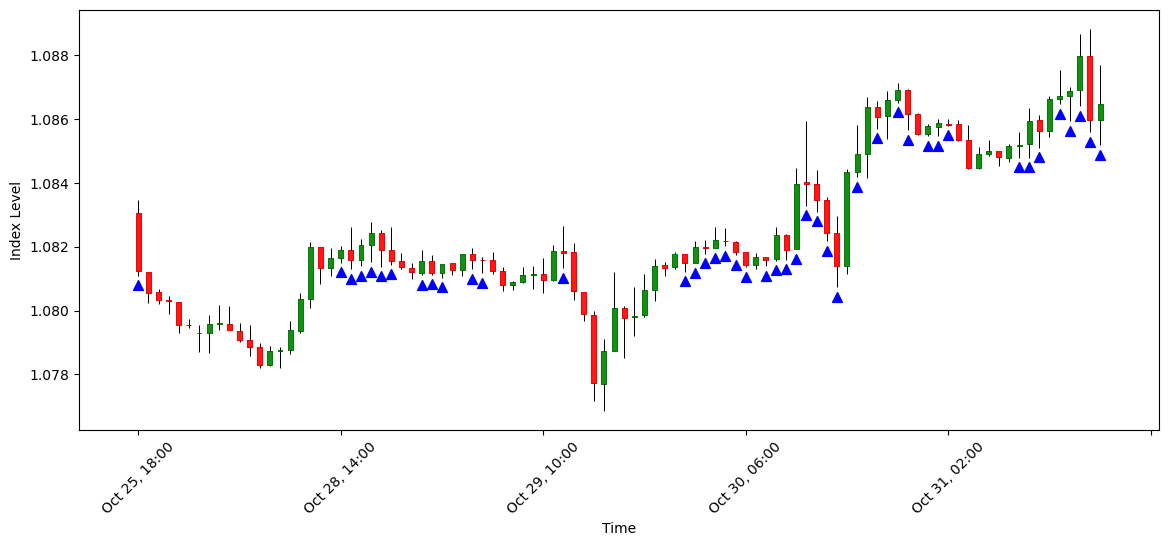

In [197]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

data = test.tail(12*8)
data.index = pd.to_datetime(data.index)

threshold = 0
threshold = 0.0005

data['ind_up'] = ((data['pred_y_up'] - data['pred_y_down']) > threshold).astype(float)
data.loc[data['ind_up'] != 1, 'ind_up'] = float("NaN")
data.loc[data['ind_up'] == 1, 'ind_up'] = data['low'] - 0.0003

data['ind_down'] = ((data['pred_y_down'] - data['pred_y_up']) > threshold).astype(float)
data.loc[data['ind_down'] != 1, 'ind_down'] = float("NaN")
data.loc[data['ind_down'] == 1, 'ind_down'] = data['high'] + 0.0003


add_plot = [
    mpf.make_addplot(data['ind_up'],
                     type='scatter', color='blue',
                     marker='^', markersize=50,
                     panel=0,
                     ),

    # mpf.make_addplot(data['ind_down'],
    #                  type='scatter', color='blue',
    #                  marker='v', markersize=50,
    #                  panel=0
    #                  )
]

mc = mpf.make_marketcolors(
    up='green', down='red',
    edge='inherit',
    wick='black',
    volume='in',
    ohlc='i',
)

s = mpf.make_mpf_style(
    marketcolors=mc,
)

mpf.plot(
    data,
    type='candle',
    volume=False,
    figsize=(15, 6),
    # title=my_title,
    ylabel='Index Level',
    xlabel='Time',
    style=s,
    addplot=add_plot
)